# Preliminary Tests and Findings

This notebook is only a preview of some of my preliminary tests. Actually, it is one of at least 25 notebooks I created for this project. Despite being one of my earliest iterations, it was still one of the best performers. My suspicions are due to the number of estimators on the model because I haven’t attempted even 10% of the number on other versions of the many models I made. One of my biggest challenges was that I wasn't able to run the code efficiently in the cloud, so I had to use my own PC to fit and predict the models.

## Early Explorations

I first started with a little EDA and basic data processing. The data comes pretty clean, but the dataset is MASSIVE. The largest I had worked with had been around 70k rows, but this one had 11 million. Not many columns though. Most columns were fairly easy to handle except for `Region_Code` and `Policy_Sales_Channel`. I treated those by binning them into a rare category due to the heavy imbalance towards some values. Otherwise, everything was treated pretty basically.

I made some basic EDA graphs to explore the data, using some base models to understand feature importances. Later, I discovered the magic of KLIB from another notebook: [Optuna XGBoost KLIB Notebook](https://www.kaggle.com/code/suvroo/ps4e7-optuna-xgboost-klib), which taught me a thing or two about cleaning the data easily with KLIB, and how to keep track of hyperparameter studies with Optuna and some of its also amazing graphs.

## Hyperparameter Studies

After doing hyperparameter studies on LightGBM, XGBoost, CatBoost, and a PyTorch neural network, I realized, while cleaning up my files, that one of my base models had the best metrics so far. That is the one I include in this notebook. 

## The Model I Picked

Below is just the code for the model; I will include my EDA in a later version. Actually this notebook is an even more simplified version of that model. i had an obsession with tuning everything with the full dataset, but realized that was taking way too much time. I tried uploading a book with some thourough feature engineering and the dummies on the categorical columns made the notebook take for than 12 hours to run and failed. This is my most barebones version with hyperparameters tuned on optuna with only 1% of the data.

At the bottom is a more thorough report of everything attempted.


In [21]:
%load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [22]:
%%capture
!pip install klib

# Importing Libraries and Datasets

In [23]:
import pandas as pd
import numpy as np
import klib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [24]:
# Load the datasets
train_data = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv", index_col='id')
test_data = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv", index_col='id')


In [25]:
train_data[['Gender', 'Vehicle_Age', 'Vehicle_Damage']] = train_data[['Gender', 'Vehicle_Age', 'Vehicle_Damage']].astype('category')

# EDA

GridSpec(6, 3)

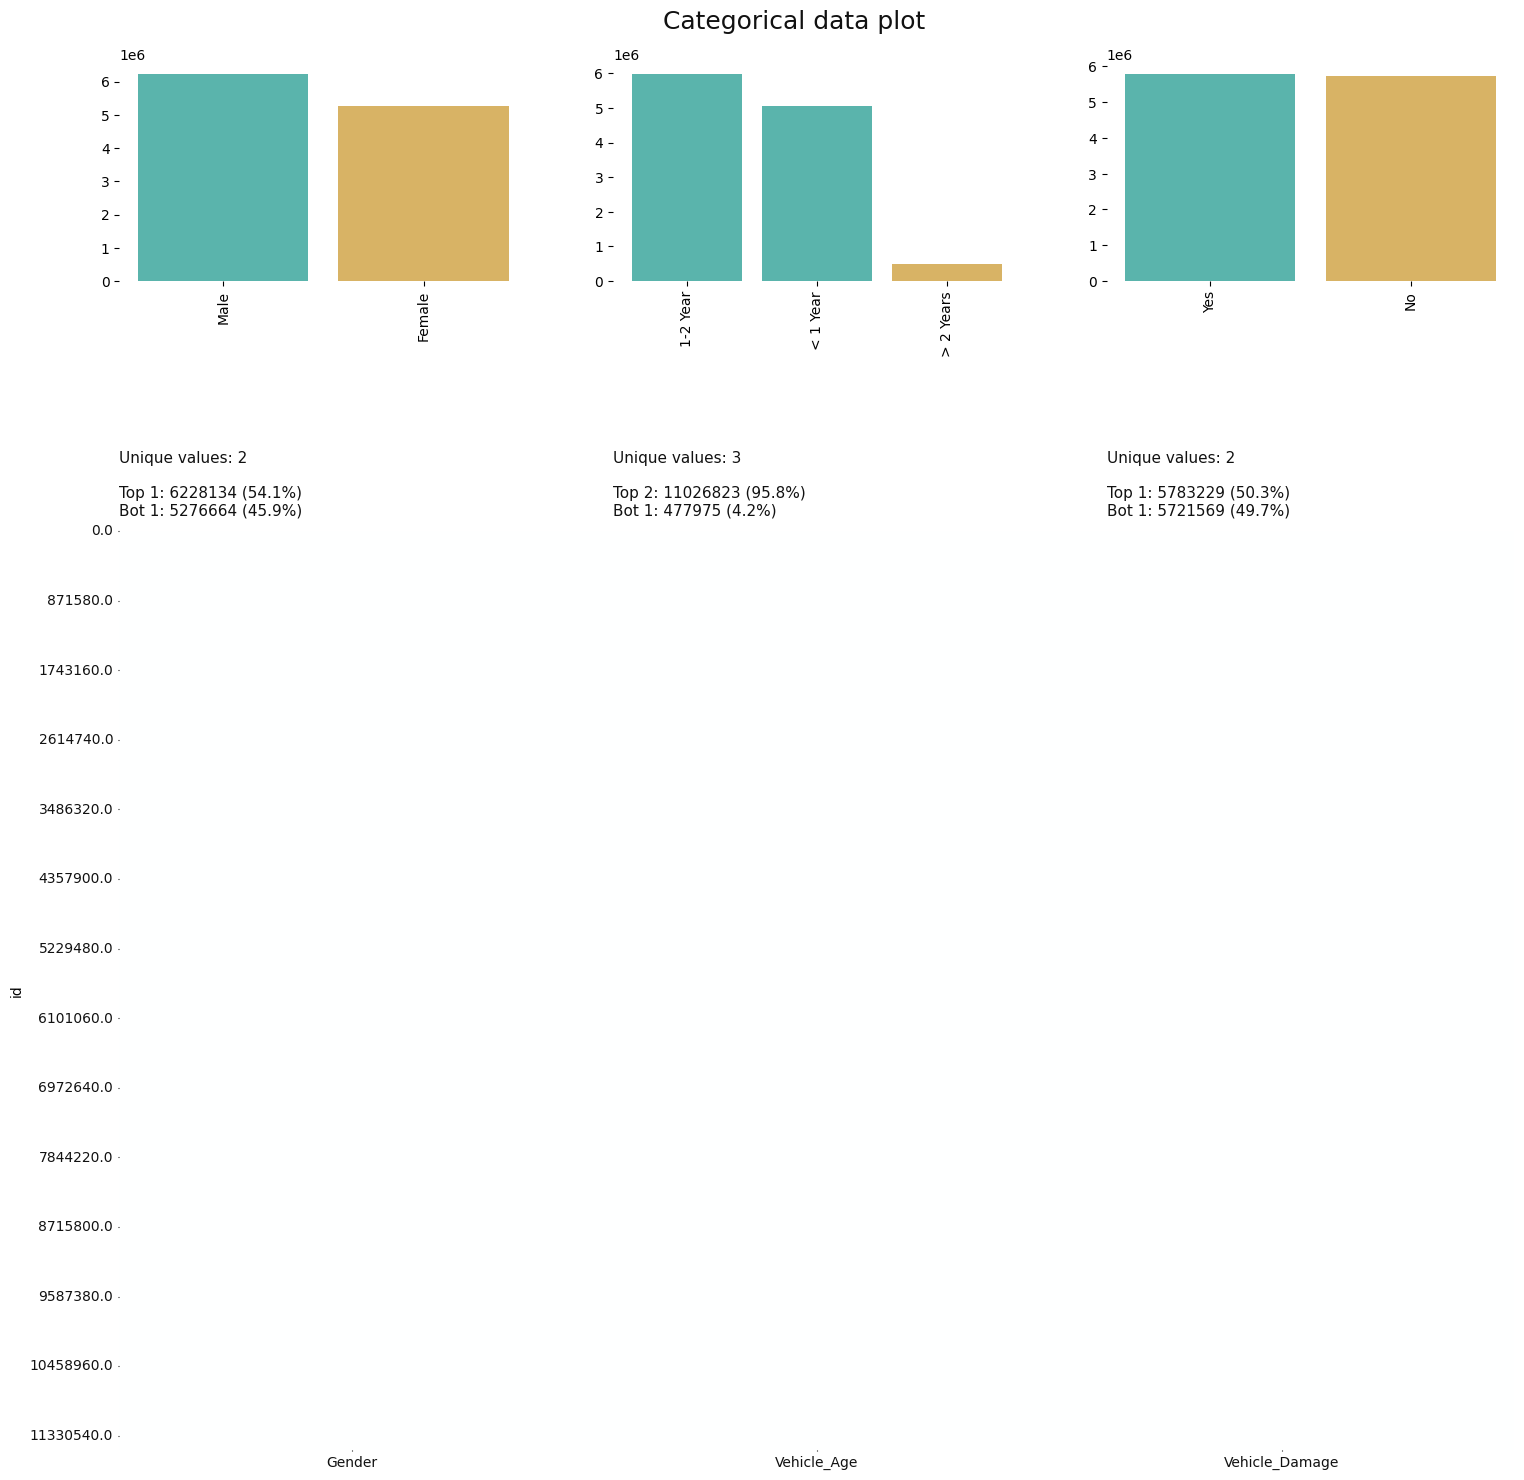

In [26]:
klib.cat_plot(train_data)

<Axes: title={'center': 'Feature-correlation (pearson)'}>

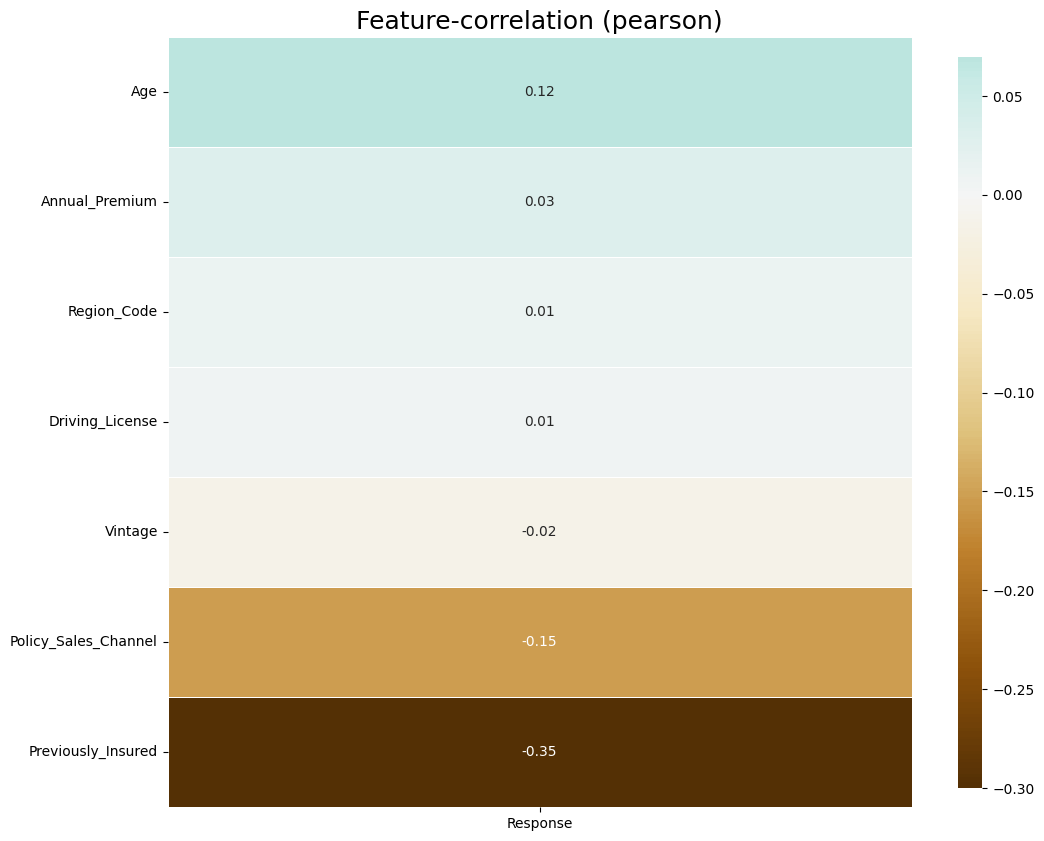

In [27]:
klib.corr_plot(train_data, target='Response')

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Vintage', ylabel='Density'>

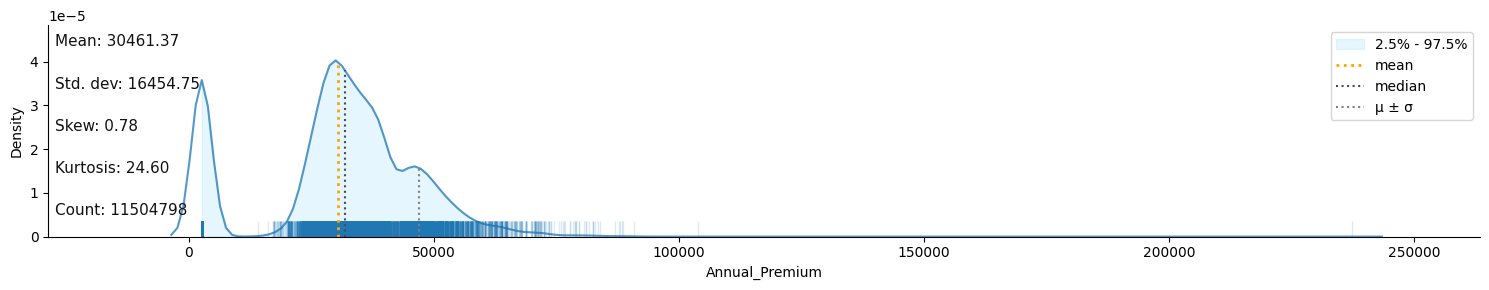

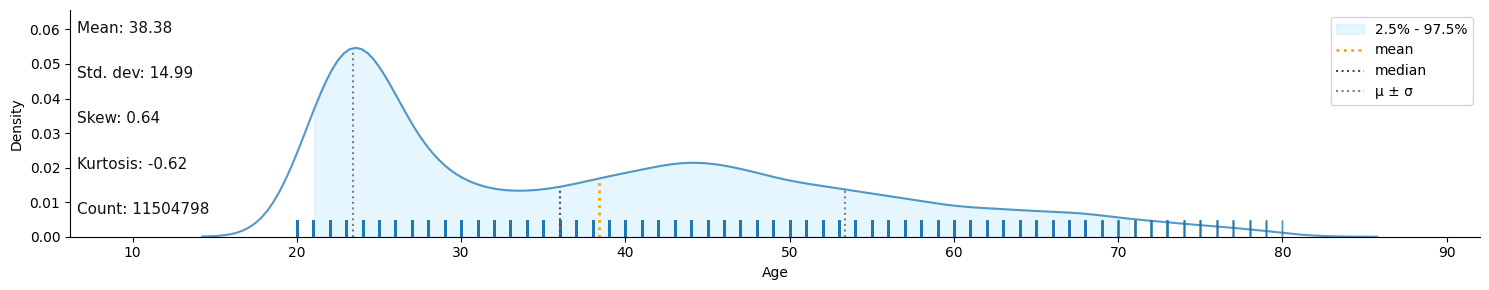

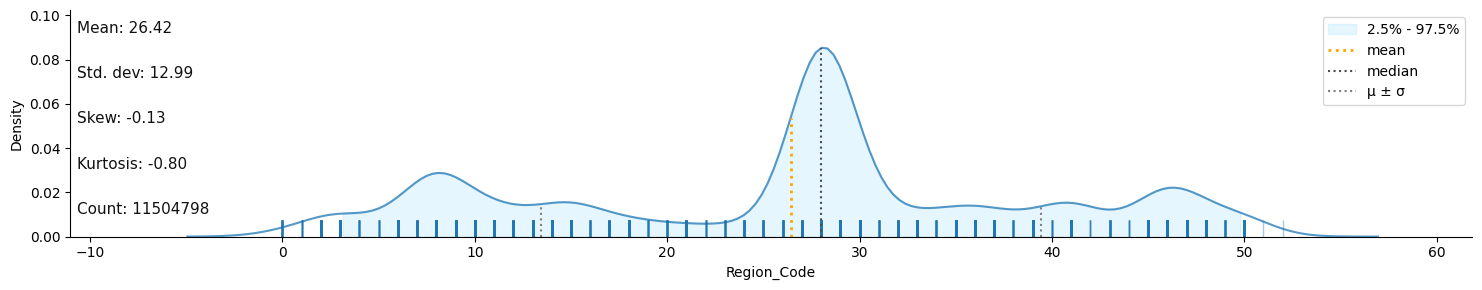

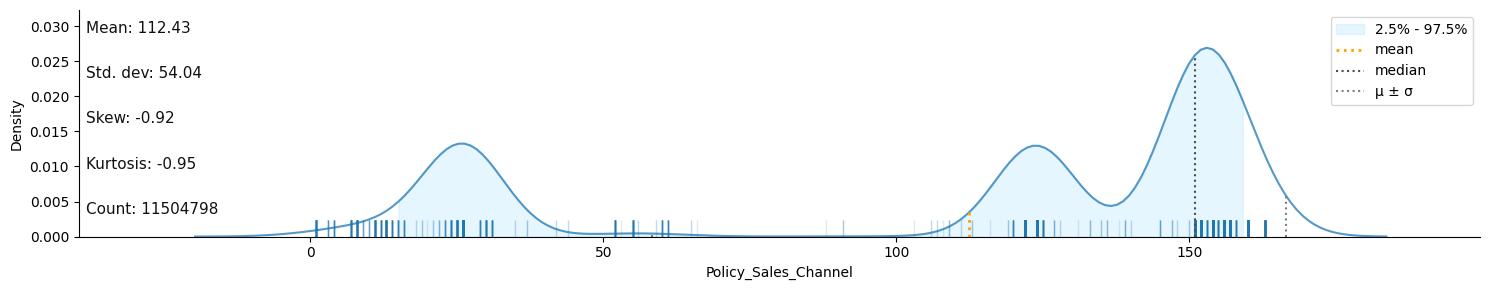

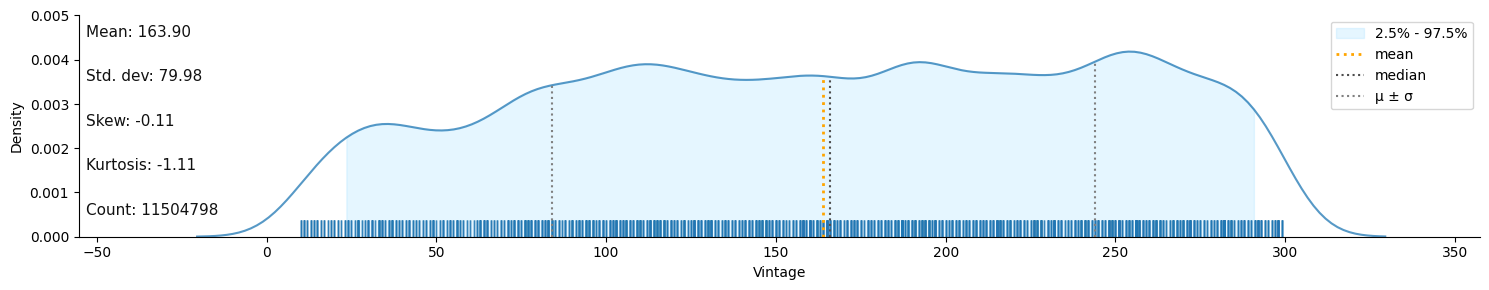

In [28]:
# Plotting categorical features against the target variable
klib.dist_plot(train_data[['Annual_Premium']])
klib.dist_plot(train_data[['Age']])
klib.dist_plot(train_data[['Region_Code']])
klib.dist_plot(train_data[['Policy_Sales_Channel']])
klib.dist_plot(train_data[['Vintage']])

# Preprocessing

In [29]:
# Preprocess data
def preprocess_data(df):
    # Transform binary variables
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
    
    # Ordinal Encoding for Vehicle_Age
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_mapping)
    
    # Drop Driving_License due to limited variability
    df.drop(['Driving_License'], axis=1, inplace=True)
    
    # Min-Max Scaling for Age and Vintage
    df['Age_MinMax'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())
    df['Vintage_MinMax'] = (df['Vintage'] - df['Vintage'].min()) / (df['Vintage'].max() - df['Vintage'].min())
    
    # Drop original Age and Vintage columns
    df.drop(columns=['Age', 'Vintage'], inplace=True)
    
    return df

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [30]:
# Convert specific columns to integers
train_data[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Age_MinMax', 'Vintage_MinMax']] = train_data[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Age_MinMax', 'Vintage_MinMax']].astype(int)
test_data[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Age_MinMax', 'Vintage_MinMax']] = test_data[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Age_MinMax', 'Vintage_MinMax']].astype(int)

# Downcasting and separating combined data

In [31]:
def optimize_dtypes(df):
   for col in df.columns:
       col_type = df[col].dtype

       if col_type != object:
           if 'int' in str(col_type):
               if df[col].min() >= -128 and df[col].max() <= 127:
                   df[col] = df[col].astype('int8')
               elif df[col].min() >= -32768 and df[col].max() <= 32767:
                   df[col] = df[col].astype('int16')
               elif df[col].min() >= -2147483648 and df[col].max() <= 2147483647:
                   df[col] = df[col].astype('int32')
               else:
                   df[col] = df[col].astype('int64')
           elif 'float' in str(col_type):
               if df[col].apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0).max() <= 4:
                   df[col] = df[col].astype('float16')
               elif df[col].apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0).max() <= 9:
                   df[col] = df[col].astype('float32')
               else:
                   df[col] = df[col].astype('float64')
    
   return df


train_data = optimize_dtypes(train_data)
test_data = optimize_dtypes(test_data)

# Removing Outliers

### You should remove outlier only from the train set.

In [32]:
# Remove outliers from Annual_Premium in training data only
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

train_data = remove_outliers_iqr(train_data, 'Annual_Premium')

# Scaling

In [33]:
# Separate numerical features
numerical_features = ['Annual_Premium', 'Age_MinMax', 'Vintage_MinMax']

In [34]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features on training data
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Transform the numerical features on test data
test_data[numerical_features] = scaler.transform(test_data[numerical_features])

# Data Split and Model Fitting

### The parameters were chosen using 100 trials on Optuna with 1% of the data.

In [35]:
# Separate target variable from training data
y = train_data['Response']
train_data.drop('Response', axis=1, inplace=True)

# Ensure that y has the same length as train_data after outlier removal
y = y.loc[train_data.index]

In [36]:
# Split the training data
X_train, X_val, y_train, y_val = train_test_split(train_data, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
X_train.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 7302020 entries, 8509689 to 6851400
Data columns (total 9 columns):
 #   Column                Dtype
---  ------                -----
 0   Gender                int8
 1   Region_Code           int8
 2   Previously_Insured    int8
 3   Vehicle_Age           int8
 4   Vehicle_Damage        int8
 5   Annual_Premium        float64
 6   Policy_Sales_Channel  int16
 7   Age_MinMax            float64
 8   Vintage_MinMax        float64
dtypes: float64(3), int16(1), int8(5)
memory usage: 271.6 MB


In [38]:
test_data.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 7669866 entries, 11504798 to 19174663
Data columns (total 9 columns):
 #   Column                Dtype
---  ------                -----
 0   Gender                int8
 1   Region_Code           int8
 2   Previously_Insured    int8
 3   Vehicle_Age           int8
 4   Vehicle_Damage        int8
 5   Annual_Premium        float64
 6   Policy_Sales_Channel  int16
 7   Age_MinMax            float64
 8   Vintage_MinMax        float64
dtypes: float64(3), int16(1), int8(5)
memory usage: 285.3 MB


In [41]:
# Final model parameters
params = {
    'reg_alpha': 0.024394503231296518,
    'reg_lambda': 0.28171247703146457,
    'colsample_bytree': 0.7,
    'subsample': 0.8,
    'learning_rate': 0.012,
    'n_estimators': 19944,
    'max_depth': 16,
    'num_leaves': 92,
    'min_child_samples': 50,
    'min_split_gain': 0.12698216620099306,
    'objective': 'binary',
    'metric': 'auc',
    'device_type': 'gpu',
}

In [ ]:
# Initialize the LightGBM model
model = lgb.LGBMClassifier(**params)

# Train the model
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 882941, number of negative: 6419079
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 7302020, number of used features: 8
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (55.71 MB) transferred to GPU in 0.090708 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120917 -> initscore=-1.983772
[LightGBM] [Info] Start training from score -1.983772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


# Evaluation

In [ ]:
# Make predictions
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate ROC AUC scores
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

# Print ROC AUC scores
print(f'Training ROC AUC Score: {roc_auc_train}')
print(f'Validation ROC AUC Score: {roc_auc_val}')

# Submission

In [ ]:
# Submission
test_predictions = model.predict_proba(test_data)[:, 1]
submission = pd.DataFrame({'id': test_data.index, 'Response': test_predictions})
submission.to_csv("submission.csv", index=False)

print("Submission file created successfully.")

## Techniques and Strategies Attempted

### Techniques for Balancing the Dataset

The target variable was highly imbalanced, so I used SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset. This technique generates synthetic samples for the minority class, but in this case in generated way too much overfitting.

## Models

### List and Description of Models Attempted

I tried out several models:

1. **Logistic Regression:** A solid baseline for binary classification.
2. **Decision Trees:** Simple and good for capturing non-linear relationships.
3. **Random Forests:** An ensemble method that improved decision tree performance.
4. **Gradient Boosting (XGBoost and LightGBM):** Advanced ensemble methods that handled the large dataset and boosted accuracy.
5. **Neural Networks:** For capturing more complex patterns in the data.
6. **Autoencoders:** These were great for feature extraction and dimensionality reduction.

### Model Selection and Evaluation

I used Stratified K-Fold Cross-Validation to ensure robust model evaluation. The models were assessed using various metrics: accuracy, precision, recall, F1-score, and AUC-ROC. Based on these metrics, I selected the best-performing model for hyperparameter tuning.

### Hyperparameter Tuning

For hyperparameter tuning, I first used GridSearchCV for an exhaustive search over specified parameter values. Then, I discovered the power of Optuna for efficient hyperparameter tuning using Bayesian optimization. When I tried RandomSearchCV the computer kept crashing.

## Experiment Tracking

### MLflow

MLflow was a game-changer for tracking my experiments. It helped me log parameters, metrics, and model versions meticulously. Detailed logs for each experiment run were maintained, which made it easier to replicate and refine my work. At the end, I opted out of it because I found manually tracking these much more convenient, or using Optuna's studies to keep track of things more easily.

## Challenges and Solutions

- **Handling Large Datasets:** The 11 million rows were daunting. I downsampled the dataset for initial exploration to manage computational resources better.
- **Imbalanced Dataset:** SMote was my go-to solution for balancing the target variable classes. SMote resulted in too much overfitting.
- **Hyperparameter Tuning:** Given the computational constraints, I leaned heavily on Optuna for efficient hyperparameter tuning. Hyperparameter tuning took almost two weeks without many gains.


